In [161]:
import matplotlib.pyplot as plt
import random
import pickle
from skimage.transform import rotate
from scipy import ndimage
from skimage.util import img_as_ubyte
from joblib import Parallel, delayed
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from itertools import product

%matplotlib inline

In [162]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def homogenize_labels(a):
    u = np.unique(a)
    return np.array([np.where(u == i)[0][0] for i in a])

In [163]:
class LifelongForest:
    """
    Lifelong Forest class.
    """
    def __init__(self, acorn=None):
        """
        Two major things the Forest Class needs access to:
            1) the realized random forest model (self.models_ is a list of forests, 1 for each task)
            2) old data (to update posteriors when a new task is introduced)
        """
        self.models_ = []
        self.X_ = []
        self.y_ = []
        self.n_tasks = 0
        self.n_classes = None
        if acorn is not None:
            np.random.seed(acorn)
    def new_forest(self, X, y, n_estimators=200, max_samples=0.32,
                        bootstrap=True, max_depth=30, min_samples_leaf=1,
                        acorn=None):
        """
        Input
        X: an array-like object of features; X.shape == (n_samples, n_features)
        y: an array-like object of class labels; len(y) == n_samples
        n_estimators: int; number of trees to construct (default = 200)
        max_samples: float in (0, 1]: number of samples to consider when 
            constructing a new tree (default = 0.32)
        bootstrap: bool; If True then the samples are sampled with replacement
        max_depth: int; maximum depth of a tree
        min_samples_leaf: int; minimum number of samples in a leaf node
        Return
        model: a BaggingClassifier fit to X, y
        """
        if X.ndim == 1:
            raise ValueError('1d data will cause headaches down the road')
        if acorn is not None:
            np.random.seed(acorn)
        self.X_.append(X)
        self.y_.append(y)
        n = X.shape[0]
        K = len(np.unique(y))
        if self.n_classes is None:
            self.n_classes = K
        max_features = int(np.ceil(np.sqrt(X.shape[1])))
        model=BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                         max_features = max_features),
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  bootstrap=bootstrap)
        model.fit(X, y)
        self.models_.append(model)
        self.n_tasks += 1
        self.n_classes = len(np.unique(y))
        return model
    def _get_leaves(self, estimator):
        """
        Internal function to get leaf node ids of estimator.
        Input
        estimator: a fit DecisionTreeClassifier
        Return
        leaf_ids: numpy array; an array of leaf node ids
        Usage
        _estimate_posteriors(..)
        """
        # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold
        leaf_ids = []
        stack = [(0, -1)] 
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()
            # If we have a test node
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                leaf_ids.append(node_id)
        return np.array(leaf_ids)
    def _finite_sample_correction(self, class_probs, row_sums):
        """
        An internal function for finite sample correction of posterior estimation.
        Input
        class_probs: numpy array; array of posteriors to correct
        row_sums: numpy array; array of partition counts
        Output
        class_probs: numpy array; finite sample corrected posteriors
        Usage
        _estimate_posteriors(..)
        """
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
        return class_probs
    def _estimate_posteriors(self, test, representation=0, decider=0, subsample=1, acorn=None):
        """
        An internal function to estimate the posteriors.
        Input
        task_number: int; indicates which model in self.model_ to use
        test: array-like; test observation
        in_task: bool; True if test is an in-task observation(s)
        subsample: float in (0, 1]; proportion of out-of-task samples to use to
            estimate posteriors
        Return
        probs: numpy array; probs[i, k] is the probability of observation i
            being class k
        Usage
        predict(..)
        """
        if acorn is not None:
            acorn = np.random.seed(acorn)
        if representation==decider:
            in_task=True
        else:
            in_task=False
        train = self.X_[decider]
        y = self.y_[decider]
        model = self.models_[representation]
        n, d = train.shape
        if test.ndim > 1:
            m, d_ = test.shape
        else:
            m = len(test)
            d_ = 1
        size = len(np.unique(y))
        class_counts = np.zeros((m, size))
        for tree in model:
            # get out of bag indicies
            if in_task:
                prob_indices = _generate_unsampled_indices(tree.random_state, n)
                # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
            else:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
            leaf_nodes = self._get_leaves(tree)
            unique_leaf_nodes = np.unique(leaf_nodes)
            # get all node counts
            node_counts = tree.tree_.n_node_samples
            # get probs for eval samples
            posterior_class_counts = np.zeros((len(unique_leaf_nodes), size))
            for prob_index in prob_indices:
                temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
                #print(y[prob_index], size, np.unique(y))
                posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
            # total number of points in a node
            row_sums = posterior_class_counts.sum(axis=1)
            # no divide by zero
            row_sums[row_sums == 0] = 1
            # posteriors
            class_probs = (posterior_class_counts / row_sums[:, None])
            # posteriors with finite sampling correction
            class_probs = self._finite_sample_correction(class_probs, row_sums)
            # posteriors as a list
            class_probs.tolist()
            partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
            # get probability for out of bag samples
            eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
            eval_class_probs = np.array(eval_class_probs)
            # find total elements for out of bag samples
            elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
            # store counts for each x (repeat fhis for each tree)
            class_counts += elems
        # calculate p(y|X = x) for all x's
        probs = class_counts / class_counts.sum(axis=1, keepdims=True)
        return probs
    def predict(self, test, representation=0, decider='all', subsample=1, acorn=None):
        """
        Predicts the class labels for each sample in test.
        Input
        test: array-like; either a 1d array of length n_features
            or a 2d array of shape (m, n_features) 
        task_number: int; task number 
        """
        size=len(np.unique(self.y_[decider]))
        sum_posteriors = np.zeros((test.shape[0], size))
        if representation is 'all':
            for i in range(self.n_tasks):
                sum_posteriors += self._estimate_posteriors(test,
                                                            i,
                                                            decider,
                                                            subsample,
                                                            acorn)
        else:
            sum_posteriors += self._estimate_posteriors(test,
                                                        representation,
                                                        decider,
                                                        subsample,
                                                        acorn)
        return np.argmax(sum_posteriors, axis=1)



In [164]:
def shape_input(pic):
    l = pic.shape[1]
    pic_ = np.uint8(np.zeros((l,l,3),dtype=int))
    
    pic_[:,:, 0] = pic[0,:,:]
    pic_[:,:, 1] = pic[1,:,:]
    pic_[:,:, 2] = pic[2,:,:]
    
    return pic_

In [165]:
def cross_val_data(data_x, data_y, total_cls=10):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]
    
    
    for i in range(total_cls):
        indx = idx[i]#np.roll(idx[i],(cv-1)*100)
        random.shuffle(indx)
        
        if i==0:
            train_x1 = x[indx[0:250],:]
            train_x2 = x[indx[250:500],:]
            train_y1 = y[indx[0:250]]
            train_y2 = y[indx[250:500]]
            
            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            train_x1 = np.concatenate((train_x1, x[indx[0:250],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x[indx[250:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:250]]), axis=0)
            train_y2 = np.concatenate((train_y2, y[indx[250:500]]), axis=0)
            
            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)
        
        
    return train_x1, train_y1, train_x2, train_y2, test_x, test_y 

In [166]:
def LF_experiment(data_x, data_y, angle, reps=1, ntrees=29, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    errors = np.zeros(2)
    
    for rep in range(reps):
        train_x1, train_y1, train_x2, train_y2, test_x, test_y = cross_val_data(data_x, data_y, total_cls=10)
    
    
        #change data angle for second task
        tmp_data = train_x2.copy()
        _tmp_ = np.zeros((3,32,32), dtype=int)
        total_data = tmp_data.shape[0]
        
        for i in range(total_data):
            tmp_ = image_aug(shape_input(tmp_data[i].reshape(3,32,32)),angle)
        
            _tmp_[0,:,:] = tmp_[:,:,0]
            _tmp_[1,:,:] = tmp_[:,:,1]
            _tmp_[2,:,:] = tmp_[:,:,2]
        
            tmp_data[i,:] = _tmp_.flatten()
        

        lifelong_forest = LifelongForest()
        lifelong_forest.new_forest(train_x1, train_y1, n_estimators=ntrees)
        lifelong_forest.new_forest(tmp_data, train_y2, n_estimators=ntrees)
    
        llf_task1=lifelong_forest.predict(test_x, representation='all', decider=0)
        llf_single_task=lifelong_forest.predict(test_x, representation=0, decider=0)
    
        m = len(test_y)
        errors[1] = errors[1]+(1 - np.sum(llf_task1 == test_y)/m)
        errors[0] = errors[0]+(1 - np.sum(llf_single_task == test_y)/m)
    
    errors = errors/reps
    print(errors,train_x1.shape,train_x2.shape,test_x.shape,angle)
    with open('/data/Jayanta/continual-learning/rotation_res_lf/'+'LF'+'_'+str(angle)+'.pickle', 'wb') as f:
        pickle.dump(errors, f)

In [167]:
def image_aug(pic, angle, centroid_x=23, centroid_y=23, win=16, scale=1.45):
    im_sz = int(np.floor(pic.shape[0]*scale))
    pic_ = np.uint8(np.zeros((im_sz,im_sz,3),dtype=int))
    
    pic_[:,:,0] = ndimage.zoom(pic[:,:,0],scale)
    pic_[:,:,1] = ndimage.zoom(pic[:,:,1],scale)
    pic_[:,:,2] = ndimage.zoom(pic[:,:,2],scale)
    
    image_aug = rotate(pic_, angle, resize=False)
    #print(image_aug.shape)
    image_aug_ = image_aug[centroid_x-win:centroid_x+win,centroid_y-win:centroid_y+win,:]
    
    return img_as_ubyte(image_aug_)

In [168]:
train_file = './cifar-100-python/train'
unpickled_train = unpickle(train_file)
train_keys = list(unpickled_train.keys())
fine_labels = np.array(unpickled_train[train_keys[2]])
labels = fine_labels

test_file = './cifar-100-python/test'
unpickled_test = unpickle(test_file)
test_keys = list(unpickled_test.keys())
fine_labels = np.array(unpickled_test[test_keys[2]])
labels_ = fine_labels

In [169]:
angles = np.arange(0,360,1)
cvs = np.arange(1,7)
task_label = range(0,10)

data_x = np.concatenate((unpickled_train[b'data'], unpickled_test[b'data']), axis=0)
data_y = np.concatenate((labels,labels_), axis=0)

class_idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]

data_x1 = np.zeros((6000,3072), dtype=int)
data_y1 = np.zeros((6000,1), dtype=int)
ind = 0

for j in range(10):
    for i in range(600):
        data_x1[ind,:] = data_x[class_idx[j][i]]
        data_y1[ind,:] = data_y[class_idx[j][i]]
        ind += 1
        
data_y1 = homogenize_labels(np.ravel(data_y1))

In [170]:
#LF_experiment(data_x1, data_y1, 1, 30, ntrees=16, acorn=1)

In [171]:
Parallel(n_jobs=-1,verbose=1)(delayed(LF_experiment)(data_x1, data_y1, angle, reps=20, ntrees=16, acorn=1) for angle in angles)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 52.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 161.5min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [175]:
iterable = product(cvs,angles)
l = len(angles)
mean_eta = np.zeros(l,dtype=float)

for count,angle in enumerate(angles):
    filename = '/data/Jayanta/continual-learning/rotation_res_lf/LF'+'_'+str(angle)+'.pickle'
    err = unpickle(filename)
    
    mean_eta[count] = err[0]/err[1]
        
print(mean_eta)

[1.05985804 1.06809121 1.05920635 1.0590242  1.07089761 1.06055595
 1.06376078 1.0659019  1.07278583 1.05857143 1.05663049 1.06263413
 1.05706179 1.05422546 1.06243595 1.06766146 1.05977831 1.05549854
 1.06158103 1.05844619 1.05655588 1.05499208 1.06971346 1.05312304
 1.05605629 1.05507636 1.05661121 1.0628821  1.06163085 1.05913725
 1.06001429 1.05504876 1.05288956 1.05449847 1.06419    1.06034825
 1.05849604 1.06090373 1.05504804 1.05288045 1.05222468 1.05926623
 1.05637467 1.05932136 1.05068257 1.05329869 1.04220728 1.05349311
 1.05594406 1.05746944 1.05426661 1.06259943 1.05150449 1.05114888
 1.05634902 1.05883281 1.05791262 1.0554376  1.05487467 1.05050267
 1.04514655 1.05216235 1.0427108  1.05132034 1.05599937 1.04635865
 1.0502947  1.05356161 1.0480113  1.04198414 1.04229513 1.04894169
 1.05142634 1.04099001 1.04893517 1.05096495 1.04344768 1.05637867
 1.04868618 1.0452937  1.04385278 1.04923319 1.05197554 1.04148183
 1.04616595 1.0459019  1.0450627  1.05497444 1.04983233 1.0465

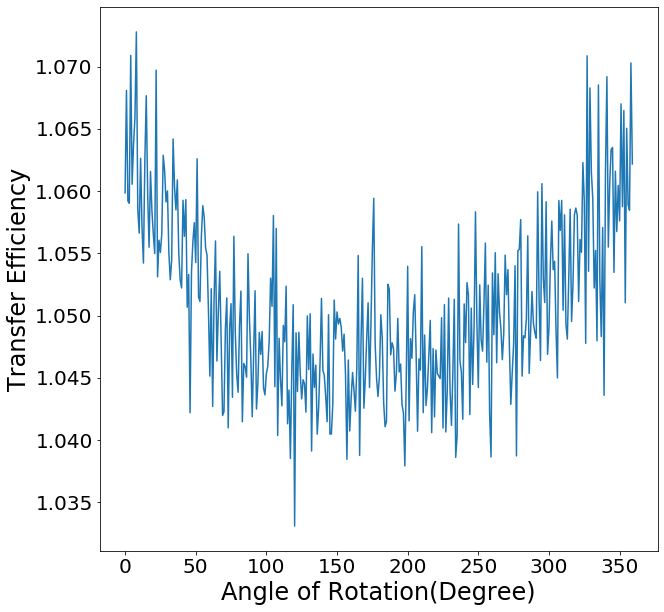

In [176]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(angles,mean_eta)

#ax.set_yticks([1.0, 1.05, 1.1])
ax.tick_params(labelsize=20)
ax.set_xlabel('Angle of Rotation(Degree)', fontsize=24)
ax.set_ylabel('Transfer Efficiency', fontsize=24)

plt.savefig('cifar-100-rotate.png')

In [97]:
a = [1,2,3,4,5]
random.shuffle(a)
print(a)

[2, 4, 1, 3, 5]
